In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import json
import talib
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras.layers.normalization import BatchNormalization

Using Theano backend.


In [3]:
from keras.utils import to_categorical
from keras.initializers import glorot_normal
from keras import regularizers

In [4]:
from matplotlib import figure

## Function Name : get_datadf
* Argument : Symbol name to download data from
* Start Time : 2012-10-11
* End Time : 2017-10-11
* URL for data download : https://query1.finance.yahoo.com/v8/finance/chart/symbol_name?period1=1349893800&period2=1507660200&interval=1d <br>

Above URL is returning JSON data with all required fields. We have parsed this JSON data to extract below fields.
* adjclose - adjusted for dividents and splits
* close - not adjusted for dividents and splits
* high
* low
* open
* volume

In [5]:
def get_datadf(symbol):
    raw_data = requests.get("https://query1.finance.yahoo.com/v8/finance/chart/"+ symbol +"?period1=1104517800&period2=1507660200&interval=1d").text
    raw_data = json.loads(raw_data)
    df = raw_data[u'chart'][u'result'][0][u'indicators'][u'quote'][0]
    df['adjclose'] = raw_data[u'chart'][u'result'][0][u'indicators'][u'adjclose'][0][u'adjclose']
    df['timestamp'] = raw_data[u'chart'][u'result'][0][u'timestamp']
    
    data = pd.DataFrame.from_dict(df)
    
    data = data.dropna()
    
    data = data[data.volume > 0]
    
    return data

## Returns
Below return functions will help us in converting the data distribution to normal distribution
### day_returns 
calculates daily return using below formula. This function we will use of daily prices <br>
(value_n - value_n-1) / value_n-1

### Log Returns
Calculates log returns of data. This function we will use to convert distribution of volume data

In [6]:
# Daily return calculated with current value and last value
def day_returns(arr):
    return (arr[1:] - arr[:-1]) / arr[:-1]

#Log return of values
def log_returns(arr):
    return np.log(arr)

# Stardize with mean 0 and standard deviation of1
def standardize(arr):
    return (arr[train_cols] - arr[train_cols].mean())/ arr[train_cols].std()

## Indicators
Right now we are using below three indicators <br>
MACD - fast 12 , slow - 26, signal line - 9 <br>
RSI - 9

In [7]:
def getIndicators(df):
    
    macdfast1, macdslow1, signal1, rsitime1 = 14, 32, 12, 14
    macdfast2, macdslow2, signal2, rsitime2 = 6, 22, 9, 9
    
    #indicators = pd.DataFrame()
    macd12, macdsignal12, macdhist12 = talib.MACD(df.adjclose.values, fastperiod=macdfast1, slowperiod=macdslow1, signalperiod=signal1)
    df.loc[:,'macd1'] = macd12
    df.loc[:,'macdsignal1'] = macdsignal12
    df.loc[:,'macdhist1'] = macdhist12 
    
    macd13, macdsignal13, macdhist13 = talib.MACD(df.adjclose.values, fastperiod=macdfast2, slowperiod=macdslow2, signalperiod=signal2)
    df.loc[:,'macd2'] = macd13
    df.loc[:,'macdsignal2'] = macdsignal13
    df.loc[:,'macdhist2'] = macdhist13 
    
    df['ema10'] = talib.EMA(df.adjclose.values, 10)
    df['ema20'] = talib.EMA(df.adjclose.values, 20)
    df['ema30'] = talib.EMA(df.adjclose.values, 30)
    df['ema40'] = talib.EMA(df.adjclose.values, 40)
    df['ema50'] = talib.EMA(df.adjclose.values, 50)
    
    rsi = talib.RSI(df.close.values, timeperiod=rsitime1)
    df.loc[:,'rsi1'] = rsi
    
    rsi = talib.RSI(df.close.values, timeperiod=rsitime2)
    df.loc[:,'rsi2'] = rsi    
    
    #indicators.index = df.index
    return df

In [8]:
def emaDiffs(df, close):
    df['ema10_20'] = df['ema10'] - df['ema20']
    df['ema10_30'] = df['ema10'] - df['ema30']
    df['ema10_40'] = df['ema10'] - df['ema40']
    df['ema10_50'] = df['ema10'] - df['ema50']
    
    df['ema20_30'] = df['ema20'] - df['ema30']
    df['ema20_40'] = df['ema20'] - df['ema40']
    df['ema20_50'] = df['ema20'] - df['ema50']
    
    df['ema30_40'] = df['ema30'] - df['ema40']
    df['ema30_50'] = df['ema30'] - df['ema50']
    
    df['ema40_50'] = df['ema40'] - df['ema50']
    
    df['ema10_close'] = df['ema10'] - close
    df['ema20_close'] = df['ema20'] - close
    df['ema30_close'] = df['ema30'] - close
    df['ema40_close'] = df['ema40'] - close
    df['ema50_close'] = df['ema50'] - close
    
    return df

In [9]:
def OHCLChanges(df):
    df['o_c'] = ( df['open'] - df['adjclose'])/ df['open']
    df['o_h'] = (df['open'] - df['high']) / df['open']
    df['o_l'] = (df['open'] - df['low'] ) / df['open']
    df['c_o'] = (df['close'] - df['open']) / df['close']
    df['c_h'] = (df['close'] - df['high']) / df['close']
    df['c_l'] = (df['close'] - df['low'] ) / df['close']
    df['h_c'] = (df['high'] - df['close']) / df['high']
    df['h_o'] = (df['high'] - df['open']) / df['high']
    df['h_c'] = (df['high'] - df['close']) / df['high']
    df['l_o'] = (df['low'] - df['open']) / df['low']
    df['l_h'] = (df['low'] - df['high']) / df['low']
    df['l_c'] = (df['low'] - df['close']) / df['low']
    
    return df

### List of top 50 stocks

In [10]:
nifty_all = ['3MINDIA.NS','8KMILES.NS','ABB.NS','ACC.NS','AIAENG.NS','APLAPOLLO.NS','AUBANK.NS','AARTIIND.NS','ABAN.NS','ADANIENT.NS','ADANIPORTS.NS','ADANIPOWER.NS','ADANITRANS.NS','ABFRL.NS','ADVENZYMES.NS','AEGISCHEM.NS','AHLUCONT.NS','AJANTPHARM.NS','AKZOINDIA.NS','APLLTD.NS','ALKEM.NS','ALBK.NS','ALLCARGO.NS','AMARAJABAT.NS','AMBUJACEM.NS','ANDHRABANK.NS','APARINDS.NS','APOLLOHOSP.NS','APOLLOTYRE.NS','ARVIND.NS','ASHOKLEY.NS','ASHOKA.NS','ASIANPAINT.NS','ASTRAZEN.NS','ASTRAL.NS','ATUL.NS','AUROPHARMA.NS','AVANTIFEED.NS','DMART.NS','AXISBANK.NS','BASF.NS','BEML.NS','BFUTILITIE.NS','BGRENERGY.NS','BSE.NS','BAJAJCORP.NS','BAJAJELEC.NS','BAJFINANCE.NS','BAJAJFINSV.NS','BAJAJHIND.NS','BAJAJHLDNG.NS','BALKRISIND.NS','BALLARPUR.NS','BALMLAWRIE.NS','BALRAMCHIN.NS','BANKBARODA.NS','BANKINDIA.NS','BATAINDIA.NS','BERGEPAINT.NS','BEL.NS','BHARATFIN.NS','BHARATFORG.NS','BHEL.NS','BPCL.NS','BHARTIARTL.NS','INFRATEL.NS','BHUSANSTL.NS','BIOCON.NS','BIRLACORPN.NS','BLISSGVS.NS','BLUEDART.NS','BLUESTARCO.NS','BBTC.NS','BOMDYEING.NS','BRFL.NS','BOSCHLTD.NS','BRIGADE.NS','BRITANNIA.NS','CARERATING.NS','CCL.NS','CESC.NS','CGPOWER.NS','CRISIL.NS','CADILAHC.NS','CANFINHOME.NS','CANBK.NS','CAPF.NS','CAPLIPOINT.NS','CARBORUNIV.NS','CASTROLIND.NS','CEATLTD.NS','CENTRALBK.NS','CENTURYPLY.NS','CENTURYTEX.NS','CERA.NS','CHAMBLFERT.NS','CHENNPETRO.NS','CHOLAFIN.NS','CIPLA.NS','CUB.NS','COALINDIA.NS','COFFEEDAY.NS','COLPAL.NS','CONCOR.NS','COROMANDEL.NS','CORPBANK.NS','COX&KINGS.NS','CROMPTON.NS','CUMMINSIND.NS','CYIENT.NS','DBREALTY.NS','DBCORP.NS','DCBBANK.NS','DCMSHRIRAM.NS','DLF.NS','DABUR.NS','DALMIABHA.NS','DEEPAKFERT.NS','DELTACORP.NS','DEN.NS','DENABANK.NS','DHFL.NS','DHANUKA.NS','DBL.NS','DISHTV.NS','DIVISLAB.NS','LALPATHLAB.NS','DRREDDY.NS','DREDGECORP.NS','EIDPARRY.NS','EIHOTEL.NS','EDELWEISS.NS','EICHERMOT.NS','EMAMILTD.NS','ENDURANCE.NS','ENGINERSIN.NS','EQUITAS.NS','EROSMEDIA.NS','ESCORTS.NS','ESSELPACK.NS','EVEREADY.NS','EXIDEIND.NS','FEDERALBNK.NS','FINCABLES.NS','FINPIPE.NS','FSL.NS','FORTIS.NS','FCONSUMER.NS','FLFL.NS','GAIL.NS','GEPIL.NS','GET&D.NS','GHCL.NS','GMRINFRA.NS','GVKPIL.NS','GDL.NS','GATI.NS','GILLETTE.NS','GSKCONS.NS','GLAXO.NS','GLENMARK.NS','GODFRYPHLP.NS','GODREJCP.NS','GODREJIND.NS','GODREJPROP.NS','GRANULES.NS','GESHIP.NS','GREAVESCOT.NS','GREENPLY.NS','GRUH.NS','GUJALKALI.NS','GUJFLUORO.NS','GUJGASLTD.NS','GMDCLTD.NS','GNFC.NS','GPPL.NS','GSFC.NS','GSPL.NS','GULFOILLUB.NS','HCLTECH.NS','HDFCBANK.NS','HSIL.NS','HTMEDIA.NS','HATHWAY.NS','HAVELLS.NS','HEIDELBERG.NS','HERITGFOOD.NS','HEROMOTOCO.NS','HEXAWARE.NS','HFCL.NS','HIMATSEIDE.NS','HINDALCO.NS','HCC.NS','HINDCOPPER.NS','HINDPETRO.NS','HINDUNILVR.NS','HINDZINC.NS','HUDCO.NS','HDFC.NS','HDIL.NS','ITC.NS','ICICIBANK.NS','ICICIPRULI.NS','ICRA.NS','IDBI.NS','IDFCBANK.NS','IDFC.NS','IFBIND.NS','IFCI.NS','IL&FSTRANS.NS','IRB.NS','ITDCEM.NS','ITI.NS','IDEA.NS','IGARASHI.NS','INDIACEM.NS','ITDC.NS','IBULHSGFIN.NS','IBREALEST.NS','IBVENTURES.NS','INDIANB.NS','INDHOTEL.NS','IOC.NS','IOB.NS','ICIL.NS','INDOCO.NS','IGL.NS','INDUSINDBK.NS','INFIBEAM.NS','NAUKRI.NS','INFY.NS','INGERRAND.NS','INOXLEISUR.NS','INOXWIND.NS','INTELLECT.NS','INDIGO.NS','IPCALAB.NS','JBCHEPHARM.NS','JKCEMENT.NS','JKIL.NS','JBFIND.NS','JKLAKSHMI.NS','JKTYRE.NS','JMFINANCIL.NS','JSWENERGY.NS','JSWSTEEL.NS','JAGRAN.NS','JAICORPLTD.NS','JISLJALEQS.NS','JPASSOCIAT.NS','JPPOWER.NS','J&KBANK.NS','JETAIRWAYS.NS','JINDALPOLY.NS','JINDALSAW.NS','JSLHISAR.NS','JSL.NS','JINDALSTEL.NS','JCHAC.NS','JUBLFOOD.NS','JUBILANT.NS','JUSTDIAL.NS','JYOTHYLAB.NS','KPRMILL.NS','KPIT.NS','KRBL.NS','KAJARIACER.NS','KALPATPOWR.NS','KANSAINER.NS','KTKBANK.NS','KARURVYSYA.NS','KSCL.NS','KEC.NS','KESORAMIND.NS','KITEX.NS','KOLTEPATIL.NS','KOTAKBANK.NS','KWALITY.NS','L&TFH.NS','LTTS.NS','LICHSGFIN.NS','LAXMIMACH.NS','LAKSHVILAS.NS','LTI.NS','LT.NS','LAURUSLABS.NS','LINDEINDIA.NS','LUPIN.NS','MMTC.NS','MOIL.NS','MRF.NS','MAGMA.NS','MGL.NS','MTNL.NS','M&MFIN.NS','M&M.NS','MAHINDCIE.NS','MHRIL.NS','MANAPPURAM.NS','MRPL.NS','MANPASAND.NS','MARICO.NS','MARKSANS.NS','MARUTI.NS','MFSL.NS','MAXINDIA.NS','MCLEODRUSS.NS','MERCK.NS','MINDTREE.NS','MINDACORP.NS','MINDAIND.NS','MONSANTO.NS','MOTHERSUMI.NS','MOTILALOFS.NS','MPHASIS.NS','MUTHOOTFIN.NS','NATCOPHARM.NS','NBCC.NS','NCC.NS','NHPC.NS','NIITTECH.NS','NLCINDIA.NS','NMDC.NS','NTPC.NS','NH.NS','NATIONALUM.NS','NFL.NS','NBVENTURES.NS','NAVINFLUOR.NS','NAVKARCORP.NS','NAVNETEDUL.NS','NETWORK18.NS','NILKAMAL.NS','OBEROIRLTY.NS','ONGC.NS','OIL.NS','OMAXE.NS','OFSS.NS','ORIENTCEM.NS','ORIENTBANK.NS','PCJEWELLER.NS','PIIND.NS','PNBHOUSING.NS','PNCINFRA.NS','PFS.NS','PTC.NS','PVR.NS','PAGEIND.NS','PARAGMILK.NS','PERSISTENT.NS','PETRONET.NS','PFIZER.NS','PHOENIXLTD.NS','PIDILITIND.NS','PEL.NS','POLARIS.NS','PFC.NS','POWERGRID.NS','PRAJIND.NS','PRESTIGE.NS','PRISMCEM.NS','PGHH.NS','PNB.NS','QUESS.NS','RBLBANK.NS','RADICO.NS','RAIN.NS','RAJESHEXPO.NS','RALLIS.NS','RAMCOSYS.NS','RKFORGE.NS','RCF.NS','RTNPOWER.NS','RAYMOND.NS','REDINGTON.NS','RELAXO.NS','RCOM.NS','RELIANCE.NS','RELINFRA.NS','RNAVAL.NS','RPOWER.NS','RELIGARE.NS','REPCOHOME.NS','RUPA.NS','RECLTD.NS','SHK.NS','SJVN.NS','SKFINDIA.NS','SMLISUZU.NS','SREINFRA.NS','SRF.NS','SADBHAV.NS','SANOFI.NS','SCHAEFFLER.NS','SCHNEIDER.NS','SHARDACROP.NS','SFL.NS','SHILPAMED.NS','SCI.NS','SHOPERSTOP.NS','SHREECEM.NS','RENUKA.NS','SHRIRAMCIT.NS','SRTRANSFIN.NS','SIEMENS.NS','SNOWMAN.NS','SOBHA.NS','SOLARINDS.NS','SOMANYCERA.NS','SONATSOFTW.NS','SOUTHBANK.NS','STARCEMENT.NS','SBIN.NS','SAIL.NS','STRTECH.NS','STAR.NS','SUDARSCHEM.NS','SPARC.NS','SUNPHARMA.NS','SUNTV.NS','SUNDRMFAST.NS','SUNTECK.NS','SUPRAJIT.NS','SUPREMEIND.NS','SUPPETRO.NS','SUVEN.NS','SUZLON.NS','SWANENERGY.NS','SYMPHONY.NS','SYNDIBANK.NS','SYNGENE.NS','TTKPRESTIG.NS','TVTODAY.NS','TV18BRDCST.NS','TVSMOTOR.NS','TVSSRICHAK.NS','TAKE.NS','TNPL.NS','TATACHEM.NS','TATACOFFEE.NS','TATACOMM.NS','TCS.NS','TATAELXSI.NS','TATAGLOBAL.NS','TATAINVEST.NS','TATAMTRDVR.NS','TATAMOTORS.NS','TATAPOWER.NS','TATASPONGE.NS','TATASTEEL.NS','TECHM.NS','TECHNO.NS','TEXRAIL.NS','RAMCOCEM.NS','THERMAX.NS','THOMASCOOK.NS','THYROCARE.NS','TIMETECHNO.NS','TIMKEN.NS','TITAN.NS','TORNTPHARM.NS','TORNTPOWER.NS','TRENT.NS','TRIDENT.NS','UCOBANK.NS','UFLEX.NS','UPL.NS','UJJIVAN.NS','ULTRACEMCO.NS','UNICHEMLAB.NS','UNIONBANK.NS','UNITECH.NS','UNITEDBNK.NS','UBL.NS','VGUARD.NS','VIPIND.NS','VRLLOG.NS','WABAG.NS','VAKRANGEE.NS','VTL.NS','VBL.NS','VEDL.NS','VESUVIUS.NS','VIDEOIND.NS','VIJAYABANK.NS','VINATIORGA.NS','VOLTAS.NS','WABCOINDIA.NS','WELCORP.NS','WELSPUNIND.NS','WHIRLPOOL.NS','WIPRO.NS','WOCKPHARMA.NS','YESBANK.NS','ZEEL.NS','ZEELEARN.NS','ZENSARTECH.NS','ECLERX.NS','ADANIPORTS.NS','ZEEL.NS'] 
#nifty_all = ['3MINDIA.NS','VGUARD.NS']

In [14]:
stocks = pd.DataFrame()

In [15]:
train_cols = ['adjclosel_', 'volumel_', 'macd1', 'macdhist1', 'macd2', 'macdhist2', 'rsi1', 'rsi2','ema10_20', 'ema10_30', 'ema10_40', 'ema10_50', 'ema20_30',
       'ema20_40', 'ema20_50', 'ema30_40', 'ema30_50', 'ema40_50','ema10_close', 'ema20_close', 'ema30_close', 'ema40_close',
       'ema50_close','o_c','o_h','o_l','c_o','c_h','c_l','h_c','h_o','h_c','l_o','l_h','l_c']

In [16]:
ret_cols = ['adjclose','open','close','high','low']
all_cols = ['adjclose','open','close','high','low','volume']
OHCL_cols = ['o_c','o_h','o_l','c_o','c_h','c_l','h_c','h_o','h_c','l_o','l_h','l_c']

for stock_sym in nifty_all:
    print(stock_sym)
    stock_data = get_datadf(stock_sym)

    stock_data = OHCLChanges(stock_data)
    stock_data = getIndicators(stock_data)
    stock_data = emaDiffs(stock_data, stock_data.adjclose)
    stock_data.index = pd.to_datetime(stock_data['timestamp'], unit='s').values

    ret = day_returns(stock_data[ret_cols].values)
    ret_df = pd.DataFrame(ret, columns=ret_cols)
    ret_df.loc[:,'volume'] = log_returns(stock_data.volume[1:]).values
    ret_df['timestamp'] = pd.to_datetime(stock_data['timestamp'], unit='s').values[1:]
    ret_df.index = ret_df.timestamp.values

    stock_alls = ret_df.join(stock_data, how='left',lsuffix='l_')

    stock_alls['next_close'] = np.zeros(stock_alls.shape[0])
    stock_alls.ix[:-1,'next_close'] = stock_alls.adjclosel_[1:].values

    stock_alls['target'] = np.zeros(stock_alls.shape[0])
    stock_alls.loc[stock_alls['next_close'] > 0.02, 'target'] = 1
    stock_alls.loc[(stock_alls['next_close'] < 0.02) & (stock_alls['next_close'] > -0.02), 'target'] = 2
    stock_alls.loc[stock_alls['next_close'] < -0.02, 'target'] = 3

    stock_df = standardize(stock_alls)
    stock_df.loc[:,'target'] = stock_alls.target.values 
    
    stocks = stocks.append(stock_df)

#stocks.index = pd.to_datetime(stocks['timestamp'], unit='s').values
#stocks.drop(['timestamp'],axis=1, inplace=True)

3MINDIA.NS


/home/rushim245/anaconda2/envs/StockML/lib/python2.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


8KMILES.NS
ABB.NS
ACC.NS
AIAENG.NS
APLAPOLLO.NS
AUBANK.NS
AARTIIND.NS
ABAN.NS
ADANIENT.NS
ADANIPORTS.NS
ADANIPOWER.NS
ADANITRANS.NS
ABFRL.NS
ADVENZYMES.NS
AEGISCHEM.NS
AHLUCONT.NS
AJANTPHARM.NS
AKZOINDIA.NS
APLLTD.NS
ALKEM.NS
ALBK.NS
ALLCARGO.NS
AMARAJABAT.NS
AMBUJACEM.NS
ANDHRABANK.NS
APARINDS.NS
APOLLOHOSP.NS
APOLLOTYRE.NS
ARVIND.NS
ASHOKLEY.NS
ASHOKA.NS
ASIANPAINT.NS
ASTRAZEN.NS
ASTRAL.NS
ATUL.NS
AUROPHARMA.NS
AVANTIFEED.NS
DMART.NS
AXISBANK.NS
BASF.NS
BEML.NS
BFUTILITIE.NS
BGRENERGY.NS
BSE.NS
BAJAJCORP.NS
BAJAJELEC.NS
BAJFINANCE.NS
BAJAJFINSV.NS
BAJAJHIND.NS
BAJAJHLDNG.NS
BALKRISIND.NS
BALLARPUR.NS
BALMLAWRIE.NS
BALRAMCHIN.NS
BANKBARODA.NS
BANKINDIA.NS
BATAINDIA.NS
BERGEPAINT.NS
BEL.NS
BHARATFIN.NS
BHARATFORG.NS
BHEL.NS
BPCL.NS
BHARTIARTL.NS
INFRATEL.NS
BHUSANSTL.NS
BIOCON.NS
BIRLACORPN.NS
BLISSGVS.NS
BLUEDART.NS
BLUESTARCO.NS
BBTC.NS
BOMDYEING.NS
BRFL.NS
BOSCHLTD.NS
BRIGADE.NS
BRITANNIA.NS
CARERATING.NS
CCL.NS
CESC.NS
CGPOWER.NS
CRISIL.NS
CADILAHC.NS
CANFINHOME.NS
CANBK.NS
CAPF.NS

In [18]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [19]:
stocks.head(20)

,adjclosel_,volumel_,macd1,macdhist1,macd2,macdhist2,rsi1,rsi2,ema10_20,ema10_30,ema10_40,ema10_50,ema20_30,ema20_40,ema20_50,ema30_40,ema30_50,ema40_50,ema10_close,ema20_close,ema30_close,ema40_close,ema50_close,o_c,o_h,o_l,c_o,c_h,c_l,h_c,h_o,h_c,l_o,l_h,l_c,target
2005-01-04 03:45:00,-0.921811,-0.216450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.276240,-0.192142,-0.749407,0.302158,0.149884,-0.468623,-0.138041,0.230416,-0.138041,0.711705,0.409105,0.460986,3.0
2005-01-05 03:45:00,-1.645569,0.501662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589615,0.725582,-0.018808,-0.572925,0.114757,-0.894803,-0.100866,-0.768296,-0.100866,0.039847,0.647237,0.856708,2.0
2005-01-06 03:45:00,-0.052881,0.343190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.586376,0.725582,0.727099,-0.569572,0.119236,0.018243,-0.105603,-0.768296,-0.105603,-0.669060,0.083798,0.001225,2.0
2005-01-07 03:45:00,0.844294,-0.349327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.725394,0.725582,1.487233,-1.787390,-1.507459,-0.797496,1.560020,-0.768296,1.560020,-1.416598,-0.510346,0.766900,2.0
2005-01-10 03:45:00,-0.742971,1.999104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.602582,0.658311,1.294799,-1.652229,-1.414533,-0.845401,1.467743,-0.693493,1.467743,-1.224884,-0.417229,0.811153,2.0
2005-01-11 03:45:00,-0.020120,0.045831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075592,0.522059,-0.422734,-0.048368,0.561550,-0.603567,-0.577688,-0.542772,-0.577688,0.413979,0.772127,0.586958,3.0
2005-01-12 03:45:00,-1.236039,1.359581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.331662,0.725582,1.937664,-1.357429,-0.933141,0.377304,0.984253,-0.768296,0.984253,-1.872071,-0.872356,-0.343226,2.0
2005-01-13 03:45:00,-0.103232,-0.673854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.861994,0.725582,0.323811,-0.857065,-0.264782,-0.894803,0.297443,-0.768296,0.297443,-0.282825,0.390777,0.856708,2.0
2005-01-14 03:45:00,-0.557708,-0.958642,NaN,NaN,NaN,NaN,NaN,-2.388399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233462,NaN,NaN,NaN,NaN,0.286121,0.663949,-0.396317,-0.261398,0.453544,-0.889674,-0.461625,-0.699752,-0.461625,0.389715,0.873052,0.851982,2.0
2005-01-17 03:45:00,-0.571815,0.256288,NaN,NaN,NaN,NaN,NaN,-2.478049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240449,NaN,NaN,NaN,NaN,0.421532,0.290816,0.172279,-0.399740,-0.201490,-0.407028,0.231445,-0.289360,0.231445,-0.139504,0.131347,0.403277,2.0


### Adding next days value as target

In [25]:
stocks['next_close'] = np.zeros(stocks.shape[0])
stocks.ix[:-1,'next_close'] = stocks.adjclosel_[1:].values

stocks['target'] = np.zeros(stocks.shape[0])
stocks.loc[stocks['next_close'] > 0.02, 'target'] = 1
stocks.loc[(stocks['next_close'] < 0.02) & (stocks['next_close'] > -0.02), 'target'] = 2
stocks.loc[stocks['next_close'] < -0.02, 'target'] = 3

/home/rushim245/anaconda2/envs/StockML/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [20]:
stocks.dropna(inplace=True)
stocks.head(10)

,adjclosel_,volumel_,macd1,macdhist1,macd2,macdhist2,rsi1,rsi2,ema10_20,ema10_30,ema10_40,ema10_50,ema20_30,ema20_40,ema20_50,ema30_40,ema30_50,ema40_50,ema10_close,ema20_close,ema30_close,ema40_close,ema50_close,o_c,o_h,o_l,c_o,c_h,c_l,h_c,h_o,h_c,l_o,l_h,l_c,target
2005-03-15 03:45:00,-0.112565,0.493751,-0.333030,-0.133372,-0.279380,0.017568,-0.902519,-0.717267,-0.301094,-0.324560,-0.357215,-0.399565,-0.336257,-0.373324,-0.421591,-0.408885,-0.463781,-0.520005,0.156808,0.233913,0.277408,0.317435,0.361325,1.013657,0.725582,0.518775,-1.017181,-0.478656,-0.889637,0.519224,-0.768296,0.519224,-0.468667,0.243070,0.851948,2.0
2005-03-16 03:45:00,0.478010,0.164393,-0.332457,-0.111998,-0.270632,0.031218,-0.699711,-0.455365,-0.293660,-0.320601,-0.354325,-0.396801,-0.337264,-0.374065,-0.421596,-0.409286,-0.463130,-0.518150,0.119615,0.205080,0.253916,0.296950,0.342577,-0.407656,-0.005579,-0.834005,0.431360,0.556185,-0.374563,-0.571910,0.031130,-0.571910,0.788112,0.627937,0.372807,2.0
2005-03-17 03:45:00,-0.446165,0.330620,-0.333824,-0.098403,-0.268529,0.029194,-0.816576,-0.615326,-0.290607,-0.319842,-0.354105,-0.396397,-0.339668,-0.375996,-0.422673,-0.410596,-0.463307,-0.517023,0.140451,0.218234,0.265354,0.307197,0.351663,0.576654,0.725582,0.087471,-0.559513,0.132672,-0.745609,-0.119818,-0.768296,-0.119818,-0.059717,0.568104,0.718881,2.0
2005-03-18 03:45:00,0.173409,-0.472689,-0.333110,-0.082082,-0.262480,0.035262,-0.722235,-0.487994,-0.284770,-0.316666,-0.351778,-0.394124,-0.340305,-0.376481,-0.422525,-0.410886,-0.462650,-0.515285,0.123006,0.203734,0.253573,0.296940,0.342161,-0.374251,-0.110661,-0.829683,0.398606,0.382141,-0.418777,-0.385176,0.143609,-0.385176,0.784215,0.536527,0.414295,2.0
2005-03-21 03:45:00,-0.434814,-0.392242,-0.334282,-0.072638,-0.262169,0.028940,-0.845223,-0.663843,-0.282928,-0.316452,-0.351933,-0.394048,-0.342317,-0.378130,-0.423422,-0.412055,-0.462792,-0.514242,0.142516,0.216473,0.264571,0.306776,0.350888,-0.041310,-0.006961,-0.484537,0.068854,0.061162,-0.502522,-0.044249,0.032613,-0.044249,0.470635,0.369700,0.492690,2.0
2005-03-22 03:45:00,-0.472237,0.327897,-0.337180,-0.068643,-0.266064,0.015690,-0.978817,-0.852687,-0.284409,-0.318775,-0.354248,-0.395906,-0.345640,-0.380906,-0.425341,-0.414101,-0.463737,-0.513908,0.160369,0.229446,0.276092,0.317228,0.360272,0.017572,0.376920,0.496268,0.009905,0.459036,0.584664,-0.467514,-0.383371,-0.467514,-0.447130,-0.041403,-0.544270,2.0
2005-03-23 03:45:00,-0.398315,0.330620,-0.341011,-0.067419,-0.271578,0.001936,-1.087443,-1.004381,-0.287575,-0.322410,-0.357706,-0.398809,-0.349691,-0.384337,-0.427877,-0.416699,-0.465207,-0.514064,0.170724,0.237929,0.284098,0.324705,0.367040,0.149717,0.215437,-0.572144,-0.123091,0.077946,-0.894803,-0.061966,-0.207397,-0.061966,0.550682,0.622363,0.856708,2.0
2005-03-24 03:45:00,0.117136,-0.067206,-0.342594,-0.061182,-0.271220,0.002371,-1.000009,-0.871262,-0.286976,-0.323036,-0.358611,-0.399476,-0.351942,-0.386312,-0.429185,-0.418289,-0.465858,-0.513627,0.151082,0.224084,0.273263,0.315512,0.358683,-0.124630,0.284540,-0.742012,0.151942,0.535857,-0.685649,-0.550031,-0.282524,-0.550031,0.705012,0.804780,0.663276,2.0
2005-03-28 03:45:00,-0.508006,-1.804659,-0.345935,-0.059973,-0.275259,-0.005846,-1.153883,-1.092958,-0.289599,-0.326157,-0.361651,-0.402057,-0.355550,-0.389448,-0.431544,-0.420780,-0.467330,-0.513909,0.169032,0.237598,0.285301,0.326497,0.368636,1.756151,0.725582,2.228977,-1.821391,-1.552875,0.087547,1.604997,-0.768296,1.604997,-2.171775,-1.110561,-0.064900,2.0
2005-03-29 03:45:00,-0.648331,1.541385,-0.351455,-0.063995,-0.283835,-0.021256,-1.345506,-1.355356,-0.295853,-0.332187,-0.367214,-0.406915,-0.360906,-0.394093,-0.435264,-0.424451,-0.469870,-0.515117,0.191042,0.255431,0.301336,0.341194,0.382069,-0.062017,-0.038141,0.508672,0.089539,0.050564,0.715953,-0.033067,0.066048,-0.033067,-0.458997,-0.410046,-0.672374,2.0


In [21]:
stocks.shape

(1252241, 36)

In [28]:
fig_size = plt.rcParams["figure.figsize"]

# Prints: [8.0, 6.0]
print "Current size:", fig_size

# Set figure width to 12 and height to 9
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

Current size: [6.0, 4.0]


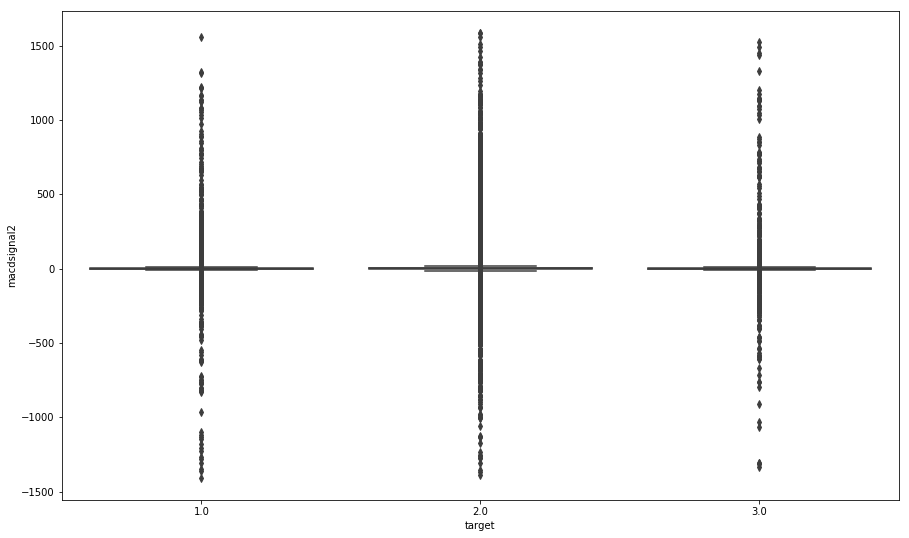

In [29]:
sns.boxplot(x = stocks.target, y=stocks.macdsignal2)

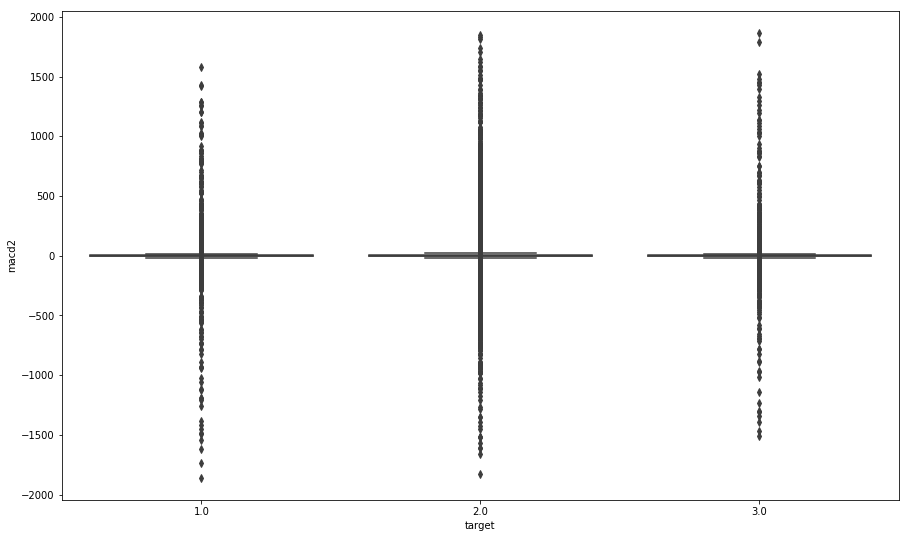

In [584]:
sns.boxplot(x = stocks.target, y=stocks.macd2)

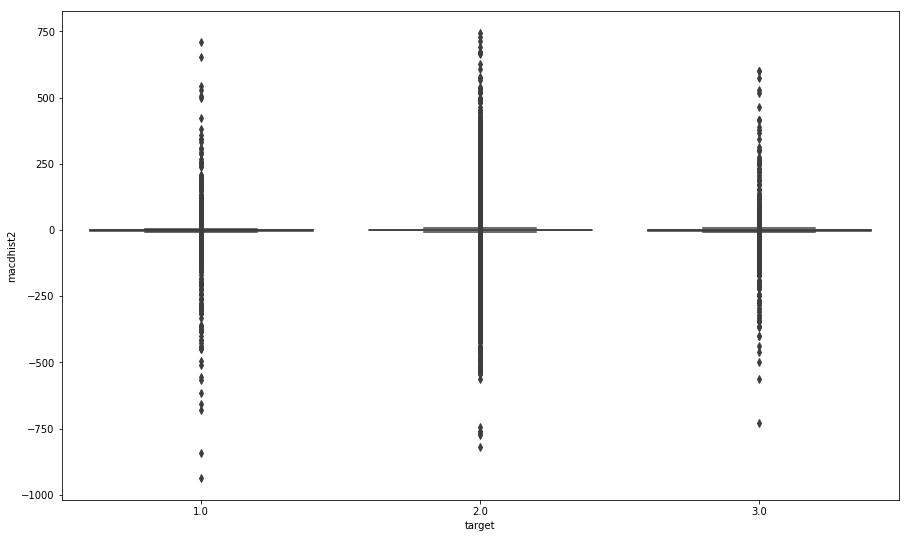

In [585]:
sns.boxplot(x = stocks.target, y=stocks.macdhist2)

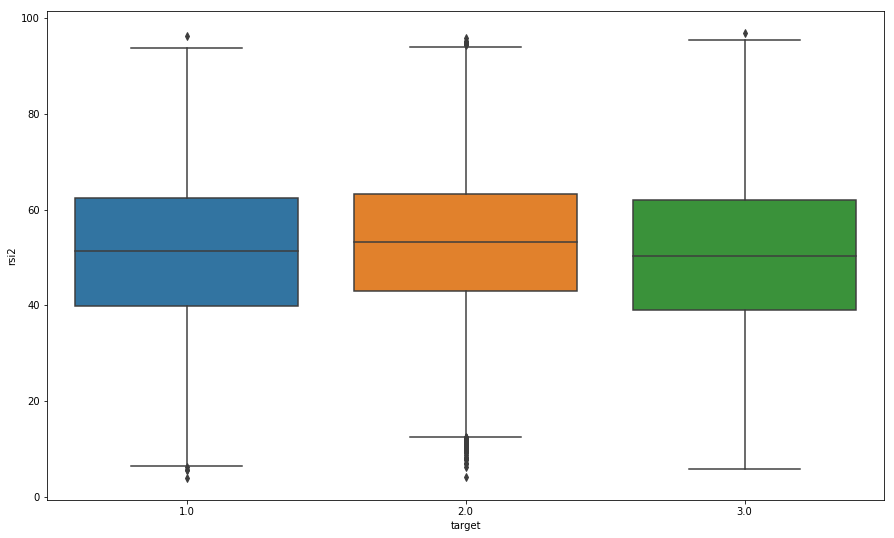

In [586]:
sns.boxplot(x = stocks.target, y=stocks.rsi2)

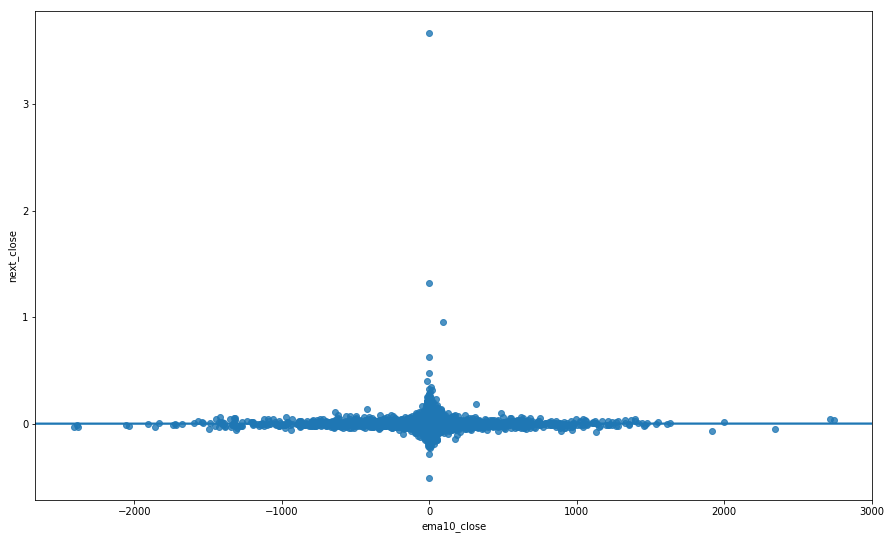

In [101]:
sns.regplot(x = stocks.ema10_close, y=stocks.next_close)

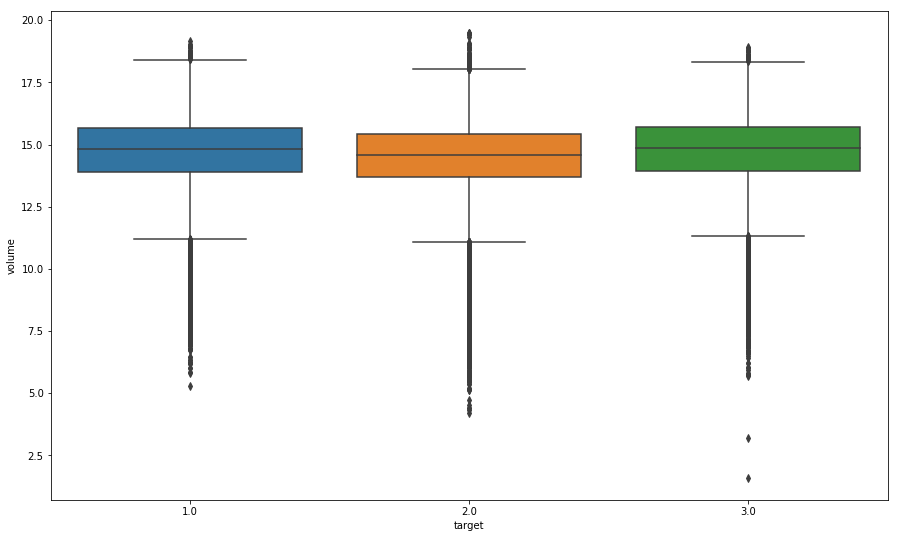

In [588]:
sns.boxplot(x = stocks.target, y=stocks.volume)

In [22]:
np.sum(stocks.target == 1) / float(stocks.shape[0])

0.17284931574672927

In [23]:
stocks.head()

,adjclosel_,volumel_,macd1,macdhist1,macd2,macdhist2,rsi1,rsi2,ema10_20,ema10_30,ema10_40,ema10_50,ema20_30,ema20_40,ema20_50,ema30_40,ema30_50,ema40_50,ema10_close,ema20_close,ema30_close,ema40_close,ema50_close,o_c,o_h,o_l,c_o,c_h,c_l,h_c,h_o,h_c,l_o,l_h,l_c,target
2005-03-15 03:45:00,-0.112565,0.493751,-0.333030,-0.133372,-0.279380,0.017568,-0.902519,-0.717267,-0.301094,-0.324560,-0.357215,-0.399565,-0.336257,-0.373324,-0.421591,-0.408885,-0.463781,-0.520005,0.156808,0.233913,0.277408,0.317435,0.361325,1.013657,0.725582,0.518775,-1.017181,-0.478656,-0.889637,0.519224,-0.768296,0.519224,-0.468667,0.243070,0.851948,2.0
2005-03-16 03:45:00,0.478010,0.164393,-0.332457,-0.111998,-0.270632,0.031218,-0.699711,-0.455365,-0.293660,-0.320601,-0.354325,-0.396801,-0.337264,-0.374065,-0.421596,-0.409286,-0.463130,-0.518150,0.119615,0.205080,0.253916,0.296950,0.342577,-0.407656,-0.005579,-0.834005,0.431360,0.556185,-0.374563,-0.571910,0.031130,-0.571910,0.788112,0.627937,0.372807,2.0
2005-03-17 03:45:00,-0.446165,0.330620,-0.333824,-0.098403,-0.268529,0.029194,-0.816576,-0.615326,-0.290607,-0.319842,-0.354105,-0.396397,-0.339668,-0.375996,-0.422673,-0.410596,-0.463307,-0.517023,0.140451,0.218234,0.265354,0.307197,0.351663,0.576654,0.725582,0.087471,-0.559513,0.132672,-0.745609,-0.119818,-0.768296,-0.119818,-0.059717,0.568104,0.718881,2.0
2005-03-18 03:45:00,0.173409,-0.472689,-0.333110,-0.082082,-0.262480,0.035262,-0.722235,-0.487994,-0.284770,-0.316666,-0.351778,-0.394124,-0.340305,-0.376481,-0.422525,-0.410886,-0.462650,-0.515285,0.123006,0.203734,0.253573,0.296940,0.342161,-0.374251,-0.110661,-0.829683,0.398606,0.382141,-0.418777,-0.385176,0.143609,-0.385176,0.784215,0.536527,0.414295,2.0
2005-03-21 03:45:00,-0.434814,-0.392242,-0.334282,-0.072638,-0.262169,0.028940,-0.845223,-0.663843,-0.282928,-0.316452,-0.351933,-0.394048,-0.342317,-0.378130,-0.423422,-0.412055,-0.462792,-0.514242,0.142516,0.216473,0.264571,0.306776,0.350888,-0.041310,-0.006961,-0.484537,0.068854,0.061162,-0.502522,-0.044249,0.032613,-0.044249,0.470635,0.369700,0.492690,2.0


In [24]:
stocks.columns

Index([u'adjclosel_', u'volumel_', u'macd1', u'macdhist1', u'macd2',
       u'macdhist2', u'rsi1', u'rsi2', u'ema10_20', u'ema10_30', u'ema10_40',
       u'ema10_50', u'ema20_30', u'ema20_40', u'ema20_50', u'ema30_40',
       u'ema30_50', u'ema40_50', u'ema10_close', u'ema20_close',
       u'ema30_close', u'ema40_close', u'ema50_close', u'o_c', u'o_h', u'o_l',
       u'c_o', u'c_h', u'c_l', u'h_c', u'h_o', u'h_c', u'l_o', u'l_h', u'l_c',
       u'target'],
      dtype='object')

In [25]:
train_cols = ['adjclosel_', 'volumel_', 'macd1', 'macdhist1', 'macd2', 'macdhist2', 'rsi1', 'rsi2','ema10_20', 'ema10_30', 'ema10_40', 'ema10_50', 'ema20_30',
       'ema20_40', 'ema20_50', 'ema30_40', 'ema30_50', 'ema40_50','ema10_close', 'ema20_close', 'ema30_close', 'ema40_close',
       'ema50_close','o_c','o_h','o_l','c_o','c_h','c_l','h_c','h_o','h_c','l_o','l_h','l_c']
out_cols = ['target']

In [50]:
stocks[train_cols].to_csv('data.csv')

In [26]:
train = stocks[train_cols].values
out = to_categorical(stocks[out_cols])

In [44]:
stocks[train_cols].head()

,adjclosel_,volumel_,macd1,macdhist1,macd2,macdhist2,rsi1,rsi2,ema10_20,ema10_30,ema10_40,ema10_50,ema20_30,ema20_40,ema20_50,ema30_40,ema30_50,ema40_50,ema10_close,ema20_close,ema30_close,ema40_close,ema50_close,o_c,o_h,o_l,c_o,c_h,c_l,h_c,h_c,h_o,h_c,h_c,l_o,l_h,l_c
2005-03-15 03:45:00,-0.112565,0.493751,-0.333030,-0.133372,-0.279380,0.017568,-0.902519,-0.717267,-0.301094,-0.324560,-0.357215,-0.399565,-0.336257,-0.373324,-0.421591,-0.408885,-0.463781,-0.520005,0.156808,0.233913,0.277408,0.317435,0.361325,1.013657,0.725582,0.518775,-1.017181,-0.478656,-0.889637,0.519224,0.519224,-0.768296,0.519224,0.519224,-0.468667,0.243070,0.851948
2005-03-16 03:45:00,0.478010,0.164393,-0.332457,-0.111998,-0.270632,0.031218,-0.699711,-0.455365,-0.293660,-0.320601,-0.354325,-0.396801,-0.337264,-0.374065,-0.421596,-0.409286,-0.463130,-0.518150,0.119615,0.205080,0.253916,0.296950,0.342577,-0.407656,-0.005579,-0.834005,0.431360,0.556185,-0.374563,-0.571910,-0.571910,0.031130,-0.571910,-0.571910,0.788112,0.627937,0.372807
2005-03-17 03:45:00,-0.446165,0.330620,-0.333824,-0.098403,-0.268529,0.029194,-0.816576,-0.615326,-0.290607,-0.319842,-0.354105,-0.396397,-0.339668,-0.375996,-0.422673,-0.410596,-0.463307,-0.517023,0.140451,0.218234,0.265354,0.307197,0.351663,0.576654,0.725582,0.087471,-0.559513,0.132672,-0.745609,-0.119818,-0.119818,-0.768296,-0.119818,-0.119818,-0.059717,0.568104,0.718881
2005-03-18 03:45:00,0.173409,-0.472689,-0.333110,-0.082082,-0.262480,0.035262,-0.722235,-0.487994,-0.284770,-0.316666,-0.351778,-0.394124,-0.340305,-0.376481,-0.422525,-0.410886,-0.462650,-0.515285,0.123006,0.203734,0.253573,0.296940,0.342161,-0.374251,-0.110661,-0.829683,0.398606,0.382141,-0.418777,-0.385176,-0.385176,0.143609,-0.385176,-0.385176,0.784215,0.536527,0.414295
2005-03-21 03:45:00,-0.434814,-0.392242,-0.334282,-0.072638,-0.262169,0.028940,-0.845223,-0.663843,-0.282928,-0.316452,-0.351933,-0.394048,-0.342317,-0.378130,-0.423422,-0.412055,-0.462792,-0.514242,0.142516,0.216473,0.264571,0.306776,0.350888,-0.041310,-0.006961,-0.484537,0.068854,0.061162,-0.502522,-0.044249,-0.044249,0.032613,-0.044249,-0.044249,0.470635,0.369700,0.492690


In [27]:
from sklearn.model_selection import train_test_split

In [31]:
trainx, testx, trainy, testy = train_test_split(train, out, test_size=0.2)

# NN Model

In [47]:
model = Sequential()
model.add(Dense(128, input_shape=(37,), activation='relu', kernel_initializer=glorot_normal(seed=22), kernel_regularizer=regularizers.l2(0.001)))
#model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_initializer=glorot_normal(seed=22), kernel_regularizer=regularizers.l2(0.001)))
#model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_initializer=glorot_normal(seed=22), kernel_regularizer=regularizers.l2(0.001)))
#model.add(BatchNormalization())

#model.add(Dense(128, activation='relu', kernel_initializer=glorot_normal(seed=22), kernel_regularizer=regularizers.l2(0.001)))
#model.add(BatchNormalization())

#model.add(Dense(128, activation='relu', kernel_initializer=glorot_normal(seed=22), kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())

model.add(Dense(4, activation='softmax', kernel_initializer=glorot_normal(seed=22)))#, kernel_regularizer=regularizers.l2(0.001)))

In [48]:
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
class_weights = {1:5, 2:1, 3:5}

In [49]:
model.fit(trainx, trainy, epochs=1000, batch_size=1024, verbose=2,validation_split=0.2)#, class_weight=class_weights)

Train on 801433 samples, validate on 200359 samples
Epoch 1/1000
5s - loss: 0.9231 - acc: 0.6677 - val_loss: 0.8540 - val_acc: 0.6689
Epoch 2/1000
5s - loss: 0.8481 - acc: 0.6680 - val_loss: 0.8443 - val_acc: 0.6687
Epoch 3/1000
26s - loss: 0.8441 - acc: 0.6680 - val_loss: 0.8420 - val_acc: 0.6686
Epoch 4/1000
44s - loss: 0.8431 - acc: 0.6679 - val_loss: 0.8418 - val_acc: 0.6687
Epoch 5/1000


KeyboardInterrupt: 

In [89]:
pred = model.predict_classes(testx)

27392/28519 [===========================>..] - ETA: 0s

In [90]:
pd.Series(pred).value_counts()

2    20495
1     4334
3     3690
dtype: int64

In [91]:
test= pd.DataFrame(testx, columns=train_cols)

In [92]:
test.loc[:,'pred'] = pred

In [94]:
test.loc[:,'target'] = np.argmax(testy,axis=1)

In [95]:
pd.crosstab(test.target.values, test.pred.values)

col_0,1.0,2.0,3.0
row_0,,,
1.0,898,2775,694
2.0,2700,15315,2267
3.0,736,2405,729


In [440]:
a
= pd.DataFrame(prob, columns=['0','1','2','3'])

In [454]:
stocks_copy = stocks.copy()

In [467]:
stocks_copy.loc[:,'pred1'] = prob['1'].values

In [470]:
stocks_copy[stocks_copy.pred1 > 0.8]

,adjclose,open,close,high,low,volume,sym,macd1,macdsignal1,macdhist1,macd2,macdsignal2,macdhist2,rsi1,rsi2,next_close,target,pred,pred1
2013-03-28 03:45:00,0.055556,0.042443,0.055556,0.058692,0.031809,14.478016,ADANIPORTS.NS,0.004218,-0.001561,0.005779,0.016366,0.001295,0.015072,57.223551,62.155941,0.027037,1.0,1,0.821315
2013-09-18 03:45:00,0.005669,-0.017279,0.005669,-0.008798,-0.002664,12.650784,ADANIPORTS.NS,0.002359,0.002425,-0.000066,0.000522,0.004170,-0.003647,50.397303,50.418850,0.036828,1.0,1,0.834594
2014-02-26 03:45:00,0.011006,-0.029421,0.011006,-0.029412,-0.020247,14.391335,ADANIPORTS.NS,0.000796,0.002699,-0.001903,-0.003771,0.002067,-0.005838,51.156554,51.746676,0.040435,1.0,1,0.817705
2014-05-15 03:45:00,0.015434,-0.033040,0.015434,-0.009374,0.000000,16.392190,ADANIPORTS.NS,0.004678,0.002175,0.002503,0.006797,0.007007,-0.000210,50.528890,50.394935,0.020871,1.0,1,0.888546
2014-05-16 03:45:00,0.020871,0.070615,0.020871,0.034331,0.016238,16.637874,ADANIPORTS.NS,0.004931,0.002599,0.002332,0.006886,0.006983,-0.000097,51.010447,51.046704,0.029556,1.0,1,0.908173
2014-06-02 03:45:00,-0.005934,0.080189,-0.005934,-0.007328,0.056840,14.666279,ADANIPORTS.NS,-0.000283,-0.000427,0.000144,0.001625,-0.002375,0.004000,49.052237,48.662804,0.062569,1.0,1,0.940969
2014-07-09 03:45:00,0.024957,-0.083481,0.024956,-0.031439,-0.016759,15.799438,ADANIPORTS.NS,0.000172,0.001709,-0.001537,-0.004484,0.002510,-0.006995,51.436639,52.095238,0.020385,1.0,1,0.999451
2016-01-27 03:45:00,-0.013965,-0.020628,-0.013965,-0.025465,-0.014925,14.599242,ADANIPORTS.NS,-0.001408,-0.001560,0.000152,-0.001335,-0.000862,-0.000473,49.120947,48.830690,-0.020896,3.0,1,0.840719
2016-02-12 03:45:00,-0.047097,-0.074138,-0.047097,-0.068848,-0.073151,16.314349,ADANIPORTS.NS,-0.008421,-0.002305,-0.006116,-0.019589,-0.006753,-0.012835,46.097048,44.725700,0.073575,1.0,1,0.835998
2016-02-17 03:45:00,0.060644,0.028389,0.060644,0.048691,0.013161,15.721920,ADANIPORTS.NS,0.007553,0.000079,0.007474,0.022872,0.003874,0.018998,56.520504,59.343262,-0.009882,2.0,1,0.878668


In [432]:
pd.crosstab(stocks.target, stocks.pred)

pred,1,2,3
target,,,
1.0,1102,6064,116
2.0,359,42739,303
3.0,110,5075,788


In [434]:
stocks.pred.value_counts()

2    53878
1     1571
3     1207
Name: pred, dtype: int64

In [435]:
stocks.target.value_counts()

2.0    43401
1.0     7282
3.0     5973
Name: target, dtype: int64